## Introduction

本实验由中国移动·九天毕昇云计算平台提供算力支持（NVIDIA V100 32G）。

## 实验介绍

### 1.实验内容

本实验包括: 
* 理解深度学习的概念，掌握常见深度学习模型及算法。
* 基于深度学习算法，实现手写体字符图像识别。

### 2.实验环境

* python 3.6.5
* numpy 1.13.3
* pandas 0.23.4 
* scikit-image 0.14.2    
* scikit-learn 0.20.2
* Pillow 5.4.1              
* tensorflow 1.12.0
* torch 1.0.0     
* torchvision 0.2.1  

### 3.数据介绍

* 数据集保存在两个文件夹中，mnist_train与mnist_test，分别作为训练数据和测试数据。
* mnist_train与mnist_test中的每个文件夹保存一类手写体图像，文件名为其类别标签。

### 4.实验准备

点击屏幕右上方的下载实验数据模块，选择下载mnist.tgz到指定目录下，然后再依次选择点击上方的File->Open->Upload,上传刚才下载的数据集压缩包，再使用如下命令解压：

In [1]:
# !tar -zxvf ./work/mnist.tgz -C ./dataset/mnist

> 注：数据量太多，建议在终端完成解压

## 正式实验

### 1. 导入需要的库

In [1]:
import sys
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np

import os
import time
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

/root/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 设置超参数
num_epochs = 50
batch_size = 64
learning_rate = 0.01

### 2. 数据集展示

In [3]:
imgs = []
for number in os.listdir('./dataset/mnist/mnist_train/'):
    print('train: {}: {}\n'.format(number, len(os.listdir('./dataset/mnist/mnist_train/' + number))))
    for imgName in os.listdir('./dataset/mnist/mnist_train/' + number):
        imgPath = './dataset/mnist/mnist_train/' + number + '/' + imgName
        img = cv2.imread(imgPath)
        imgs.append(img)
        break

train: 8: 5851

train: 3: 6131

train: 9: 5949

train: 2: 5958

train: 4: 5842

train: 1: 6742

train: 0: 5923

train: 5: 5421

train: 7: 6265

train: 6: 5918



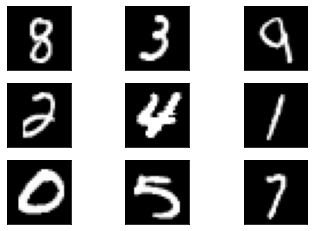

In [4]:
fig, axes = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(imgs[i*3+j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

### 3. 经典CNN模型复现

#### 3.1 AlexNet

In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### 3.2 VGG16

In [7]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### 3.3 ResNet18

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### 4. 设置损失函数和优化方法

In [9]:
## AlexNet
# model = AlexNet(num_classes=10)
## VGG16
# model = models.vgg16(pretrained=True)
# model.classifier[6] = nn.Linear(4096, 10)
## ResNet18
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# 损失函数与优化器
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[0.9, 0.999], amsgrad=True)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### 5. 封装训练和测试函数

In [11]:
def train_model(model, Loss, bestLoss, data_loader, criterion, bestPath, lastPath, lossPath):
    model = model.to(device)
    model.train()
    # 开始迭代
    for epoch in range(num_epochs):
        # 显示进度条
        train_bar = tqdm(data_loader, file = sys.stdout, ncols = 100)
        # 批处理
        tmp_loss = 0
        for i, (images, labels) in enumerate(train_bar):

            images = images.to(device); labels = labels.to(device)
            
            # 前向传播
            outputs = model(images)            
            loss = criterion(outputs, labels)
            tmp_loss += loss.item()
            # 反向优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            train_bar.desc = "train epoch[{}/{}] loss:{:.6f}".format(epoch + 1, num_epochs, loss)
        tmp_loss /= len(data_loader)
        Loss.append(tmp_loss)
        if tmp_loss<bestLoss:
            bestLoss = tmp_loss
            torch.save(model.state_dict(), bestPath)
            print("===save best model==")
            print("===best loss: {}===".format(bestLoss))
                
    torch.save(model.state_dict(), lastPath)
    print("===save last model===")
    
    plt.plot(Loss)
   
    my_str = ' '.join(map(str, Loss))+'\n'
    with open(lossPath, 'w') as f:
        f.write(my_str)

    print('Finished!')
    return Loss

In [12]:
def val_model(model, split_loader):
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        correct = 0; total = 0
        val_bar = tqdm(split_loader, file=sys.stdout, ncols=100) 
        for i, (images, labels) in enumerate(val_bar):
            images = images.to(device); labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_accurate = correct / total
            
            if (i + 1) % 10 == 0:
                print('\n[epoch %d] val_accuracy: %.6f' %  (i + 1, val_accurate))
        print(correct)
        print(total)
    return val_accurate

### 6. 模型训练

### 6.1 读取数据


In [13]:
data_path = './dataset/mnist/'
lastPath = './models/mnist/ResNet18_last.pt'
bestPath = './models/mnist/ResNet18_best.pt'
lossPath = './models/mnist/ResNet18_loss.txt'

In [14]:
import shutil
## 清理数据文件夹
for split in ['mnist_train', 'mnist_test']:
    if os.path.exists(data_path+split+'/'+'.ipynb_checkpoints'):
        print('delete {}'.format(data_path+split+'/'+'.ipynb_checkpoints'))
        shutil.rmtree(data_path+split+'/'+'.ipynb_checkpoints')
    for label in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
        if os.path.exists(data_path+split+'/'+label+'/'+'.ipynb_checkpoints'):
            print('delete {}'.format(data_path+split+'/'+label+'/'+'.ipynb_checkpoints'))
            shutil.rmtree(data_path+split+'/'+label+'/'+'.ipynb_checkpoints')

In [15]:
# 设置设备
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
num_workers = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # 用于加载数据集的进程数量
print('Using {} dataloader workers every process'.format(num_workers))

cuda:0
Using 8 dataloader workers every process


In [16]:
# 配置data_loader
data_transform = {
    'train': transforms.Compose([
                                transforms.Resize([224, 224]),                        # 将图像尺寸调整为224 * 224
                                transforms.ToTensor(),                         # 将图像转换为张量
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
                                transforms.Resize([224, 224]),                        # 将图像尺寸调整为224 * 224
                                transforms.ToTensor(),                         # 将图像转换为张量
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])}


# 加载训练集
train_dataset = torchvision.datasets.ImageFolder(root = os.path.join(data_path, 'mnist_train'), transform=data_transform['train'])
# 加载测试集
test_dataset = torchvision.datasets.ImageFolder(root = os.path.join(data_path, 'mnist_test'), transform=data_transform['test'])
train_num = len(train_dataset)
test_num = len(test_dataset)

# 配置Data loader，一次训练载入一个batch_size的数据
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print("using {} images for training, {} images for test.".format(train_num, test_num))
print(train_loader.dataset.class_to_idx)

using 60000 images for training, 10000 images for test.
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


### 6.2 正式训练

In [17]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
if os.path.exists(lastPath):
    model.load_state_dict(torch.load(lastPath))
    print("===load last model===")
else:
    print("===No saved model===")

===No saved model===


In [19]:
if os.path.exists(lossPath):
    lossdf = pd.read_table(lossPath, header=None, sep=" ")
    Loss = lossdf.iloc[0, :].tolist()
    print('lowest loss is {}'.format(min(Loss)))
else:
    Loss = []
    print("===No saved Loss===")

===No saved Loss===


In [ ]:
# 正式训练
Loss = train_model(model, Loss, 1, data_loader=train_loader, criterion=criterion, bestPath=bestPath, lastPath=lastPath, lossPath=lossPath)

train epoch[1/50] loss:0.095938: 100%|████████████████████████████| 938/938 [16:52<00:00,  1.08s/it]
===save best model==
===best loss: 0.12184363638032486===
train epoch[2/50] loss:0.038103: 100%|████████████████████████████| 938/938 [09:18<00:00,  1.68it/s]
===save best model==
===best loss: 0.031511080033151555===
train epoch[3/50] loss:0.003502:  57%|███████████████▉            | 532/938 [06:05<04:16,  1.58it/s]

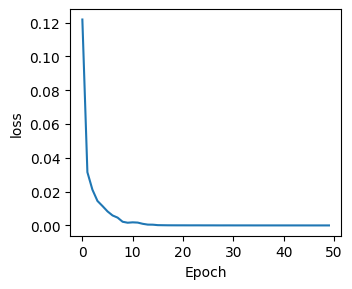

In [24]:
plt.figure(figsize=(3.5, 3), dpi=100)
plt.plot(Loss)
plt.xlabel('Epoch', size = 10)
plt.ylabel('loss', size=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./figures/ResNet18.pdf', format='pdf', dpi=300, bbox_inches='tight')

### 7. 模型评估

In [26]:
if os.path.exists(bestPath):
    print('===load best model===')
    model.load_state_dict(torch.load(bestPath))

===load best model===


In [27]:
train_acc = val_model(model, train_loader)
print(train_acc)

  1%|▌                                                              | 9/938 [00:13<18:17,  1.18s/it]
[epoch 10] val_accuracy: 1.000000
  2%|█▎                                                            | 19/938 [00:18<13:07,  1.17it/s]
[epoch 20] val_accuracy: 1.000000
  3%|█▊                                                            | 27/938 [00:25<20:05,  1.32s/it]
[epoch 30] val_accuracy: 1.000000
  4%|██▌                                                           | 38/938 [00:31<09:35,  1.56it/s]
[epoch 40] val_accuracy: 1.000000
  5%|███▏                                                          | 49/938 [00:44<17:07,  1.16s/it]
[epoch 50] val_accuracy: 1.000000
  6%|███▉                                                          | 59/938 [00:50<10:07,  1.45it/s]
[epoch 60] val_accuracy: 1.000000
  7%|████▌                                                         | 69/938 [00:56<08:21,  1.73it/s]
[epoch 70] val_accuracy: 1.000000
  8%|█████▏                                            

In [28]:
test_acc = val_model(model, test_loader)
print(test_acc)

  5%|███▏                                                           | 8/157 [00:12<01:48,  1.37it/s]
[epoch 10] val_accuracy: 1.000000
 11%|███████                                                       | 18/157 [00:24<02:49,  1.22s/it]
[epoch 20] val_accuracy: 0.999219
 18%|███████████▍                                                  | 29/157 [00:31<01:44,  1.22it/s]
[epoch 30] val_accuracy: 0.999479
 24%|██████████████▌                                               | 37/157 [00:36<01:12,  1.64it/s]
[epoch 40] val_accuracy: 0.998828
 31%|██████████████████▉                                           | 48/157 [00:43<00:57,  1.89it/s]
[epoch 50] val_accuracy: 0.999062
 38%|███████████████████████▎                                      | 59/157 [00:57<01:43,  1.06s/it]
[epoch 60] val_accuracy: 0.998698
 44%|███████████████████████████▏                                  | 69/157 [01:07<01:27,  1.00it/s]
[epoch 70] val_accuracy: 0.997768
 49%|██████████████████████████████▍                   

### 8. 结论

### 8.1 模型评估

|Model|Dataset|Correct|Total|Accuracy|
| :---: | :---: | :---: | :---: | :---: |
|AlexNet|Training|59991|60000|99.98%|
|AlexNet|Testing|9958|10000|99.58%|
|VGG16|Training|60000|60000|100%|
|VGG16|Testing|9963|10000|99.63%|
|ResNet18|Training|60000|60000|100%|
|ResNet18|Testing|9962|10000|99.62%|

### 8.2 Loss曲线（Training）

分别是AlexNet、VGG16、ResNet18的Loss曲线

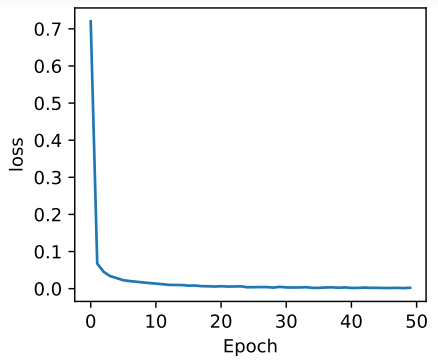
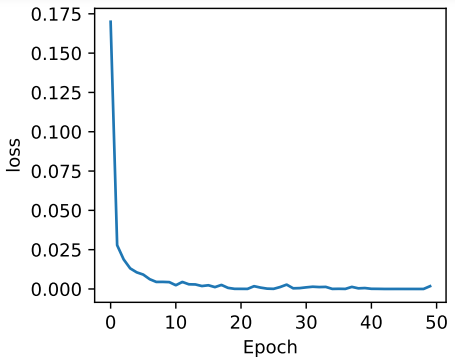
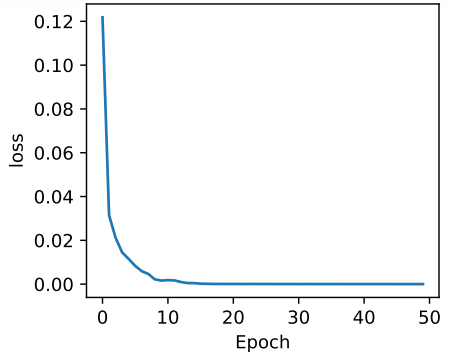

### 8.3 实验感悟

- 使用深度学习模型应当考虑模型复杂度与数据复杂度需相匹配
- AlexNet结构简单，参数少，训练快，在MNIST数据集上的性能表现与其他两个深度卷积神经网络的性能相当
- VGG模型参数量较大，调参很困难，笔者在训练的时候出现了Loss不收敛的情况，因此在实验中采用了Pytorch提供的预训练模型，在此基础上做迁移学习